
### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline


## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

In [3]:
# A:
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
house.columns

Index([u'Id', u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea',
       u'Street', u'Alley', u'LotShape', u'LandContour', u'Utilities',
       u'LotConfig', u'LandSlope', u'Neighborhood', u'Condition1',
       u'Condition2', u'BldgType', u'HouseStyle', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'RoofStyle',
       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'MasVnrArea', u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual',
       u'BsmtCond', u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1',
       u'BsmtFinType2', u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF',
       u'Heating', u'HeatingQC', u'CentralAir', u'Electrical', u'1stFlrSF',
       u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'KitchenQual', u'TotRmsAbvGrd', u'Functional',
       u'Fireplaces', u'FireplaceQu', u'GarageType', u'GarageYrBlt',
       u'GarageFinish',

Dividing the column names into fixed and variable features. A lot of assumptions included in here. For example, the porch is broken down in sqft by type of porch. That might be easily changable, but since that is difficult to know on a case by case level, I have deemed it a fixed characteristic. 

In [328]:
fixed = [u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea',
       u'Street', u'Alley', u'LotShape', u'LandContour',u'Utilities',
       u'LotConfig', u'LandSlope', u'Neighborhood', u'Condition1',
       u'Condition2', u'BldgType', u'HouseStyle', u'YearBuilt', u'YearRemodAdd', u'RoofStyle',
       u'RoofMatl',u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'MasVnrArea',u'Foundation',u'BsmtExposure',u'TotalBsmtSF',u'1stFlrSF',
       u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'TotRmsAbvGrd',u'Fireplaces',u'GarageType', u'GarageYrBlt',
        u'GarageCars', u'GarageArea',u'WoodDeckSF', u'OpenPorchSF',
       u'EnclosedPorch', u'3SsnPorch', u'ScreenPorch', u'PoolArea',u'MiscFeature', u'MiscVal']

variable = [u'OverallQual',
       u'OverallCond',u'ExterQual', u'ExterCond',u'BsmtQual',
       u'BsmtCond',u'BsmtFinType1',u'BsmtFinSF1',
       u'BsmtFinType2', u'BsmtFinSF2', u'BsmtUnfSF',u'Heating', u'HeatingQC', u'CentralAir', u'Electrical',
          u'KitchenQual', u'Functional',u'FireplaceQu',u'GarageFinish',u'GarageCond', u'PavedDrive',u'PoolQC',
       u'Fence']

sale = [u'MoSold', u'YrSold', u'SaleType',
       u'SaleCondition', u'SalePrice']

In [706]:
len(fixed)

49

In [80]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

Initializing a copy of the DF to clean up so I can revert back to original if necessary

In [329]:
house_clean = house.copy()

In [330]:
# drop non-residential houses - removes 10 values

house_clean.drop(house_clean[house_clean['MSZoning'] == 'C (all)'].index,inplace=True)

In [331]:
house_clean.shape

(1450, 81)

I want to drop any column that gives data on fewer than 5%-10% of all rows. For example "Street" has paved for 1446 items vs gravel for 4 items, I dont consider the 4 outliers a large enough percentage for the model. 

    - Street (only 4 gravel)
    - Alley (only 89 alleys)
    - Land Contour (90% level)
    - Utilities (1 non-All)
    - Land Slope (95% gentle)
    - Condition2 (99% norm)
    - RoofMat1 (98% standard)
    - Heating (97% GasA)
    - Central Air (93% yes)
    - Electrical (92% Standard Circuit Breakers)
    
However I am going to wait to let tuning decide this, as it is relatively straightforward to keep the categories in with the dummy variables created below. 

In [ ]:
for i in range(1,len(house_clean.columns)):
    print house_clean.iloc[:,i].value_counts()

Create dummy variables out of the categorical features (now have 289 columns)

In [332]:
dummies = pd.get_dummies(house_clean,drop_first=True, dummy_na=True)
dummies.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,1,0,0,0,0,1,0,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,1,0,0,0,0,1,0,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,1,0,0,0,0,1,0,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,0,1,0,0,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,1,0,0,0,0,1,0,0


Subclass is numerical but is really a category so creating a dummy variable for it. 

In [333]:
SubClass_dummy = pd.get_dummies(dummies['MSSubClass'],prefix='MSSubClass', drop_first=True)

In [334]:
house_clean_dummies = pd.concat([dummies,SubClass_dummy],axis=1)

In [335]:
house_clean_dummies.drop('MSSubClass',axis=1,inplace=True)

In [336]:
house_clean_dummies.head()

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190
0,1,65.0,8450,7,5,2003,2003,196.0,706,0,...,1,0,0,0,0,0,0,0,0,0
1,2,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,0,0,0,0,0,0,0
2,3,68.0,11250,7,5,2001,2002,162.0,486,0,...,1,0,0,0,0,0,0,0,0,0
3,4,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,1,0,0,0,0,0,0,0,0
4,5,84.0,14260,8,5,2000,2000,350.0,655,0,...,1,0,0,0,0,0,0,0,0,0


Looking for missing values in numerical columns. In categorical columns, missing value meant the category was not applicable, therefore conveying meaning about the property - say the absense of a basement.

In [337]:
house_clean_dummies.iloc[:,:37].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 37 columns):
Id               1450 non-null int64
LotFrontage      1191 non-null float64
LotArea          1450 non-null int64
OverallQual      1450 non-null int64
OverallCond      1450 non-null int64
YearBuilt        1450 non-null int64
YearRemodAdd     1450 non-null int64
MasVnrArea       1442 non-null float64
BsmtFinSF1       1450 non-null int64
BsmtFinSF2       1450 non-null int64
BsmtUnfSF        1450 non-null int64
TotalBsmtSF      1450 non-null int64
1stFlrSF         1450 non-null int64
2ndFlrSF         1450 non-null int64
LowQualFinSF     1450 non-null int64
GrLivArea        1450 non-null int64
BsmtFullBath     1450 non-null int64
BsmtHalfBath     1450 non-null int64
FullBath         1450 non-null int64
HalfBath         1450 non-null int64
BedroomAbvGr     1450 non-null int64
KitchenAbvGr     1450 non-null int64
TotRmsAbvGrd     1450 non-null int64
Fireplaces       1450 non-null int64
G

Based on this, we have missing values in 3 numerical categories - Lot Frontage, Masonry veneer area and garage year built. For Masonry veneer area, I assume missing really means none so I will make the values 0 sqft. For Lot Frontage, I will impute the column mean. I am going to drop the garage year built column, because I there seem to be sufficient markers for when the house production occured. 

In [338]:
house_clean_dummies.drop('GarageYrBlt',axis=1,inplace=True)

In [339]:
house_clean_dummies['LotFrontage'].fillna(house_clean_dummies['LotFrontage'].mean(),inplace=True)

In [340]:
house_clean_dummies['MasVnrArea'].fillna(0, inplace=True)

In [341]:
house_clean_dummies.any().isnull().value_counts()

False    301
dtype: int64

Now free of null values, we can start spliting our data for training and testing. Training on houses sold before 2010 then testing on houses sold in 2010. 

In [342]:
train = house_clean_dummies[house_clean_dummies['YrSold'] < 2010]
test = house_clean_dummies[house_clean_dummies['YrSold'] == 2010]
print train.shape
print test.shape

(1278, 301)
(172, 301)


The first model is only for features of the house considered fixed, so we will subset on training and test sets by the fixed features defined above. Leaves us with 191 columns. 

In [343]:
fixed_dummy_cols = []
for i in house_clean_dummies.columns:
    for k in fixed:
        if k in i:
            fixed_dummy_cols.append(i)
len(fixed_dummy_cols)

191

In [344]:
house_clean_dummies.columns

Index([u'Id', u'LotFrontage', u'LotArea', u'OverallQual', u'OverallCond',
       u'YearBuilt', u'YearRemodAdd', u'MasVnrArea', u'BsmtFinSF1',
       u'BsmtFinSF2',
       ...
       u'MSSubClass_60', u'MSSubClass_70', u'MSSubClass_75', u'MSSubClass_80',
       u'MSSubClass_85', u'MSSubClass_90', u'MSSubClass_120',
       u'MSSubClass_160', u'MSSubClass_180', u'MSSubClass_190'],
      dtype='object', length=301)

Also need the sales features

In [345]:
sale_dummy_cols = []
for i in house_clean_dummies.columns:
    for k in sale:
        if k in i:
            sale_dummy_cols.append(i)
sale_dummy_cols

['MoSold',
 'YrSold',
 'SalePrice',
 'SaleType_CWD',
 'SaleType_Con',
 'SaleType_ConLD',
 'SaleType_ConLI',
 'SaleType_ConLw',
 'SaleType_New',
 'SaleType_Oth',
 'SaleType_WD',
 'SaleType_nan',
 'SaleCondition_AdjLand',
 'SaleCondition_Alloca',
 'SaleCondition_Family',
 'SaleCondition_Normal',
 'SaleCondition_Partial',
 'SaleCondition_nan']

In [563]:
train_fixed = train[fixed_dummy_cols+sale_dummy_cols]
test_fixed = test[fixed_dummy_cols+sale_dummy_cols]
train_fixed.shape

(1278, 209)

In [564]:
test_fixed.shape

(172, 209)

In [253]:
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn.metrics import r2_score

In [254]:
lr = LinearRegression()

In [565]:
X_train_fixed = train_fixed.drop('SalePrice', axis=1)
y_train_fixed = train_fixed['SalePrice']

X_test_fixed = test_fixed.drop('SalePrice', axis=1)
y_test_fixed = test_fixed['SalePrice']

In [348]:
baseline = y_train_fixed.mean()
baseline

181654.94206896552

In [566]:
model = lr.fit(X_train_fixed, y_train_fixed)

scores = cross_val_score(lr, X_train_fixed, y_train_fixed, cv=10)

print np.mean(scores), np.std(scores), scores


0.627260034357 0.281461875732 [ 0.04809001  0.21136905  0.90009082  0.67613963  0.87797023  0.57977954
  0.83476753  0.81159033  0.49066365  0.84213956]


Lets see if we can do better...

First we scale our X variables so we can perform reguluarization. I use an elastic net model to determine the penalty and magnitude of said penalty to improve the model. The results suggest a Lasso (l1) penalty with an alpha of 1127. The process left 67 non-zero variables. The new model produces an R^2 of 0.855 indicating it captures about 85% of the variance. 

In [209]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [567]:
ss = StandardScaler()

X_train_fixed_std = ss.fit_transform(X_train_fixed)
X_test_fixed_std = ss.fit_transform(X_test_fixed)

In [635]:
elasticnet_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], n_alphas=100, cv=10)

In [636]:
elasticnet_model.fit(X_train_fixed_std,y_train_fixed)

ElasticNetCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
       l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=1000,
       n_alphas=100, n_jobs=1, normalize=False, positive=False,
       precompute='auto', random_state=None, selection='cyclic',
       tol=0.0001, verbose=0)

In [637]:
print elasticnet_model.l1_ratio_
print elasticnet_model.alpha_
print elasticnet_model.coef_

1.0
1125.0520456
[  0.00000000e+00   1.00477994e+03   6.73892530e+03   7.67302468e+03
   3.52336395e+03   6.03768452e+03   0.00000000e+00   0.00000000e+00
  -2.58765042e+02   2.83276717e+04   4.27876800e+03   0.00000000e+00
   2.42290351e+03   0.00000000e+00  -1.53163962e+03  -5.23052297e+03
   9.82472154e+02   4.10486594e+03   8.81946144e+03   0.00000000e+00
   1.44431486e+03   2.43841247e+02  -0.00000000e+00   3.74087636e+00
   1.56961182e+03   0.00000000e+00  -0.00000000e+00  -0.00000000e+00
   0.00000000e+00  -1.19038168e+03   0.00000000e+00   0.00000000e+00
   0.00000000e+00  -0.00000000e+00   0.00000000e+00   1.06768728e+03
  -1.40434159e+03  -0.00000000e+00   0.00000000e+00   5.85553778e+02
  -0.00000000e+00   0.00000000e+00   0.00000000e+00  -0.00000000e+00
   0.00000000e+00   2.16896404e+03  -0.00000000e+00  -0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00  -0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.34822258e+02
  -1.85116535e+02

In [641]:
elasticnet_model.score(X_test_fixed_std,y_test_fixed)

0.87147076210394547

Visualizing the predictions against the actual sale prices demonstrates and interesting pattern. The model looks to do worse for higher "actual values," consistantly overpredicting. This leads me to wonder if there is a logarithmic relationship where housing prices end up slowing in growth as certain fixed features rise linearly. 

0.871470762104


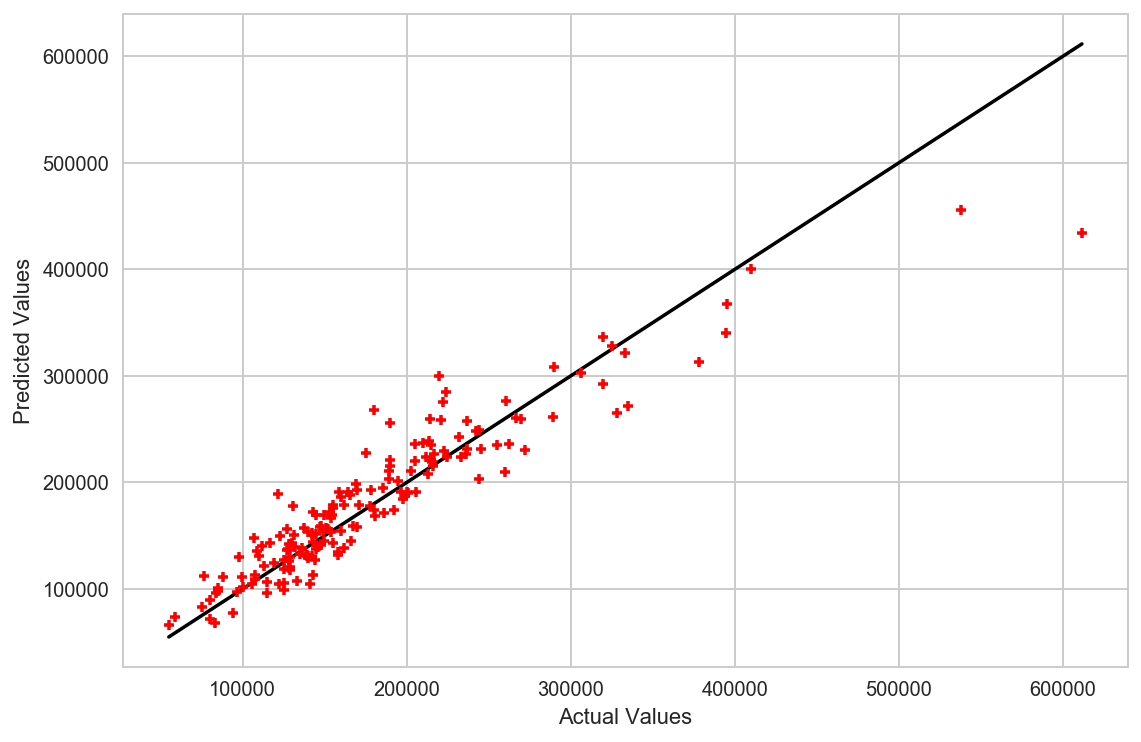

In [642]:
predictions = elasticnet_model.predict(X_test_fixed_std)
    
print elasticnet_model.score(X_test_fixed_std,y_test_fixed)

plt.figure(figsize=(9,6))
plt.scatter(y_test_fixed, predictions, s=30, c='r', marker='+', zorder=10)
plt.plot([min(y_test_fixed),max(y_test_fixed)],[min(y_test_fixed),max(y_test_fixed)],c='k')
plt.ylabel('Predicted Values')
plt.xlabel('Actual Values')
plt.show()


In [573]:
model_cols = []
for i, j in enumerate(elasticnet_model.coef_):
    if abs(j) > 0:
        model_cols.append(i)

In [574]:
fixed_features = fixed_dummy_cols+sale_dummy_cols[0:2]+sale_dummy_cols[3:]

fixed_model_columns = [fixed_features[i] for i in model_cols]
fixed_model_coefs = [i for i in elasticnet_model.coef_ if abs(i) > 0]
feature_df = pd.DataFrame({'features': fixed_model_columns, 'coefs':fixed_model_coefs})

In [575]:
feature_df['abs_effect'] = abs(feature_df.coefs)

Here we take a look at the beta coefficients. Below shows the features sorted by absolute magnitude. The original coefs show whether the feature has positive or negative effect on sale price. 

A few things stand out:
    - Space has the largest effect - between GrLivArea, GarageCars and TotalBsmtSF
    - Neighborhood has a strong effect
    - The year built and remodeled both have large positive effect. 

In [576]:
feature_df.sort_values('abs_effect',ascending=False)

,coefs,features,abs_effect
6,28327.671658,GrLivArea,28327.671658
31,12878.717220,Neighborhood_NridgHt,12878.717220
13,8819.461444,GarageCars,8819.461444
30,8298.325016,Neighborhood_NoRidge,8298.325016
2,7673.024683,YearRemodAdd,7673.024683
34,7230.855602,Neighborhood_StoneBr,7230.855602
49,7123.139327,RoofMatl_WdShngl,7123.139327
1,6738.925303,YearBuilt,6738.925303
4,6037.684524,TotalBsmtSF,6037.684524
10,-5230.522971,KitchenAbvGr,5230.522971


For easy of viewing, the columns are broken down into continuous and categorical variables. We can see 18 continuous variables remain and 49 categorical variables remain. 

In [579]:
feature_df[~feature_df['features'].str.contains('_')]

,coefs,features,abs_effect
0,1004.779944,LotArea,1004.779944
1,6738.925303,YearBuilt,6738.925303
2,7673.024683,YearRemodAdd,7673.024683
3,3523.363945,MasVnrArea,3523.363945
4,6037.684524,TotalBsmtSF,6037.684524
5,-258.765042,LowQualFinSF,258.765042
6,28327.671658,GrLivArea,28327.671658
7,4278.768000,BsmtFullBath,4278.768000
8,2422.903506,FullBath,2422.903506
9,-1531.639620,BedroomAbvGr,1531.639620


In [522]:
feature_df[feature_df['features'].str.contains('_')]

,coefs,features,abs_effect
18,-1347.129836,MSZoning_RM,1347.129836
19,787.095194,LotShape_IR2,787.095194
20,-1475.842721,LotShape_IR3,1475.842721
21,864.890289,LandContour_HLS,864.890289
22,1921.967620,LotConfig_CulDSac,1921.967620
23,332.279790,Neighborhood_BrkSide,332.279790
24,3976.878738,Neighborhood_Crawfor,3976.878738
25,-2439.199677,Neighborhood_Edwards,2439.199677
26,-351.117102,Neighborhood_Gilbert,351.117102
27,-732.011617,Neighborhood_MeadowV,732.011617


As noted above, there looks to be some sort of logarithmic relationship. Therefore, I attempted to rerun the model against a log-scale for the target (sale price). 

In [638]:
elasticnet_model2 = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], n_alphas=100, cv=10)

In [639]:
elasticnet_model2.fit(X_train_fixed_std,np.log(y_train_fixed))

ElasticNetCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
       l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=1000,
       n_alphas=100, n_jobs=1, normalize=False, positive=False,
       precompute='auto', random_state=None, selection='cyclic',
       tol=0.0001, verbose=0)

In [640]:
print elasticnet_model2.l1_ratio_
print elasticnet_model2.alpha_
print elasticnet_model2.coef_

0.1
0.0553394255831
[ 0.          0.00599607  0.03391117  0.05428535  0.00729719  0.02463821
  0.0161548   0.01374076 -0.          0.08126896  0.02371589  0.          0.0242719
  0.00873665  0.         -0.02423333  0.01882668  0.03167025  0.04335888
  0.01746562  0.01262907  0.00814033  0.          0.00169083  0.01212882
 -0.          0.         -0.          0.         -0.01850265  0.          0.
  0.          0.00023636  0.          0.00291834 -0.00726436 -0.          0.
  0.00090329 -0.          0.          0.         -0.          0.          0.008739
 -0.         -0.         -0.          0.          0.         -0.          0.
 -0.         -0.          0.00039197  0.          0.          0.02305866
 -0.01591276 -0.00014884 -0.         -0.01500211 -0.00506161 -0.00022362
 -0.         -0.          0.01760962  0.03456539 -0.00585165 -0.
 -0.00171149  0.          0.01645662  0.02213894  0.0030747   0.00374247
  0.         -0.00308952  0.01025467  0.          0.         -0.00082226
  0.  

The model improves by about 3%, it drops a few fewer features and now uses a penalty much closer to ridge despite dropping many features to 0. 

In [643]:
elasticnet_model2.score(X_test_fixed_std,np.log(y_test_fixed))

0.90336586896170423

0.903365868962


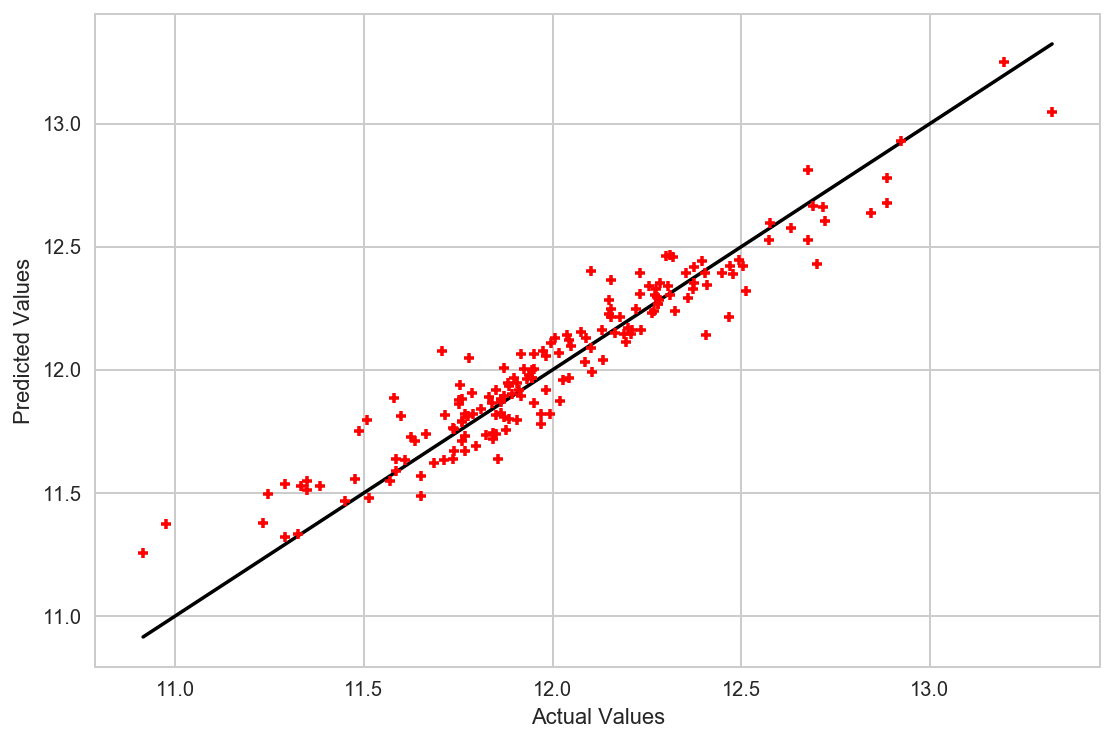

In [644]:
predictions2 = elasticnet_model2.predict(X_test_fixed_std)
    
print elasticnet_model2.score(X_test_fixed_std,np.log(y_test_fixed))

plt.figure(figsize=(9,6))
plt.scatter(np.log(y_test_fixed), predictions2, s=30, c='r', marker='+', zorder=10)
plt.plot([min(np.log(y_test_fixed)),max(np.log(y_test_fixed))],[min(np.log(y_test_fixed)),max(np.log(y_test_fixed))],c='k')
plt.ylabel('Predicted Values')
plt.xlabel('Actual Values')
plt.show()

In [645]:
model_cols2 = []
for i, j in enumerate(elasticnet_model2.coef_):
    if abs(j) > 0:
        model_cols2.append(i)

In [646]:
fixed_model_columns2 = [fixed_features[i] for i in model_cols2]
fixed_model_coefs2 = [i for i in elasticnet_model2.coef_ if abs(i) > 0]
feature_df3 = pd.DataFrame({'features': fixed_model_columns2, 'coefs':fixed_model_coefs2})

In [647]:
feature_df3['abs_effect'] = abs(feature_df3.coefs)

In [648]:
feature_df3['abs_effect'] = feature_df3['abs_effect'].apply(lambda x: '{:.10f}'.format(x))

In [719]:
feature_df3.sort_values('abs_effect',ascending=False)

,coefs,features,abs_effect
7,0.081269,GrLivArea,0.0812689604
2,0.054285,YearRemodAdd,0.0542853495
14,0.043359,GarageCars,0.0433588791
34,0.034565,Neighborhood_NridgHt,0.0345653902
1,0.033911,YearBuilt,0.0339111701
13,0.031670,Fireplaces,0.0316702504
4,0.024638,TotalBsmtSF,0.0246382071
9,0.024272,FullBath,0.0242719017
11,-0.024233,KitchenAbvGr,0.0242333252
8,0.023716,BsmtFullBath,0.0237158924


In [750]:
top_10 = feature_df3.sort_values('abs_effect',ascending=False).head(15)

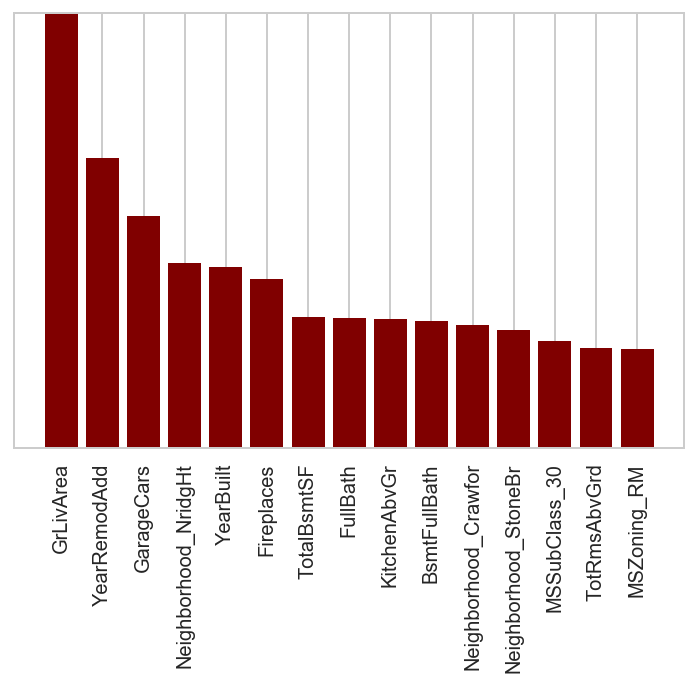

In [755]:
y_pos = np.arange(len(top_10['features']))
plt.bar(y_pos,top_10['abs_effect'],color=['maroon'])
plt.xticks(y_pos, top_10['features'],rotation='vertical')
plt.yticks([])
plt.ylim((0,0.0812689604))
plt.figure(figsize=(3,100))
plt.show()


In [715]:
feature_df3[~feature_df3['features'].str.contains('_')].sort_values('abs_effect', ascending=False)

,coefs,features,abs_effect
7,0.081269,GrLivArea,0.0812689604
2,0.054285,YearRemodAdd,0.0542853495
14,0.043359,GarageCars,0.0433588791
1,0.033911,YearBuilt,0.0339111701
13,0.031670,Fireplaces,0.0316702504
4,0.024638,TotalBsmtSF,0.0246382071
9,0.024272,FullBath,0.0242719017
11,-0.024233,KitchenAbvGr,0.0242333252
8,0.023716,BsmtFullBath,0.0237158924
12,0.018827,TotRmsAbvGrd,0.0188266845


In [714]:
feature_df3[feature_df3['features'].str.contains('_')].sort_values('abs_effect', ascending=False)

,coefs,features,abs_effect
34,0.034565,Neighborhood_NridgHt,0.0345653902
27,0.023059,Neighborhood_Crawfor,0.0230586578
38,0.022139,Neighborhood_StoneBr,0.0221389423
66,-0.020092,MSSubClass_30,0.0200923979
20,-0.018503,MSZoning_RM,0.0185026490
33,0.017610,Neighborhood_NoRidge,0.0176096215
37,0.016457,Neighborhood_Somerst,0.0164566174
69,-0.016134,MSSubClass_160,0.0161341014
28,-0.015913,Neighborhood_Edwards,0.0159127633
30,-0.015002,Neighborhood_MeadowV,0.0150021062



## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

Determine new targets by calculating residuals from log model. 

In [650]:
# A:
predictions_train = elasticnet_model2.predict(X_train_fixed_std)
predictions_test = elasticnet_model2.predict(X_test_fixed_std)


In [680]:
y_train_var = np.log(y_train_fixed) - predictions_train
y_test_var = np.log(y_test_fixed) - predictions_test

In [681]:
print y_train_var.mean()
print y_train_var.std()

-1.98762932734e-16
0.135597236366


Subset my variable columns

In [682]:
variable_dummy_cols = []
for i in house_clean_dummies.columns:
    for k in variable:
        if k in i:
            variable_dummy_cols.append(i)
len(variable_dummy_cols)

91

In [668]:
X_train_var = train[variable_dummy_cols]
X_test_var = test[variable_dummy_cols]
print X_train_var.shape
print X_test_var.shape

(1278, 91)
(172, 91)


Check an unregularized fit for context

In [683]:
model = lr.fit(X_train_var, y_train_var)

scores = cross_val_score(lr, X_train_var, y_train_var, cv=10)

print np.mean(scores), np.std(scores), scores


0.0383258271851 0.233680037929 [-0.00899954  0.21076226  0.27271536  0.04733418  0.20843976  0.01530289
  0.08074276  0.31264298 -0.43334843 -0.32233395]


Initialize new elasticnet model for variable features and target residuals. 

In [684]:
X_train_var_std = ss.fit_transform(X_train_var)
X_test_var_std = ss.fit_transform(X_test_var)

In [685]:
elasticnet_model3 = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], n_alphas=100, cv=10)

In [686]:
elasticnet_model3.fit(X_train_var_std,y_train_var)

ElasticNetCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
       l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=1000,
       n_alphas=100, n_jobs=1, normalize=False, positive=False,
       precompute='auto', random_state=None, selection='cyclic',
       tol=0.0001, verbose=0)

In [687]:
print elasticnet_model3.l1_ratio_
print elasticnet_model3.alpha_
print elasticnet_model3.coef_

0.5
0.0121399586959
[  3.38599620e-02   3.07286357e-02  -0.00000000e+00   0.00000000e+00
  -0.00000000e+00  -0.00000000e+00   0.00000000e+00  -0.00000000e+00
   0.00000000e+00  -0.00000000e+00  -0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -0.00000000e+00  -0.00000000e+00
  -0.00000000e+00   0.00000000e+00   0.00000000e+00  -0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
  -0.00000000e+00   0.00000000e+00  -1.15522001e-02   0.00000000e+00
  -0.00000000e+00   0.00000000e+00   0.00000000e+00  -0.00000000e+00
  -0.00000000e+00   0.00000000e+00  -0.00000000e+00   1.69437635e-03
  -4.37897379e-03  -0.00000000e+00  -0.00000000e+00   0.00000000e+00
  -4.25256649e-04  -2.10755654e-05  -0.00000000e+00  -0.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -0.00000000e+00  -0.00000000e+00
   0.00000000e+00   0.00000000e+00   2.11050906e-03   0.00000000e+00
   0.00000000e+00  -0.00000000e+00  -0.00000000e+00  -5.02837694e-03
   0.00000000e

The model performs ok considering both the success of the previous model and that we are attempting to predict remaining variance from given housing characteristics. 

In [688]:
elasticnet_model3.score(X_test_var_std,y_test_var)

0.079638205635899739

0.0796382056359


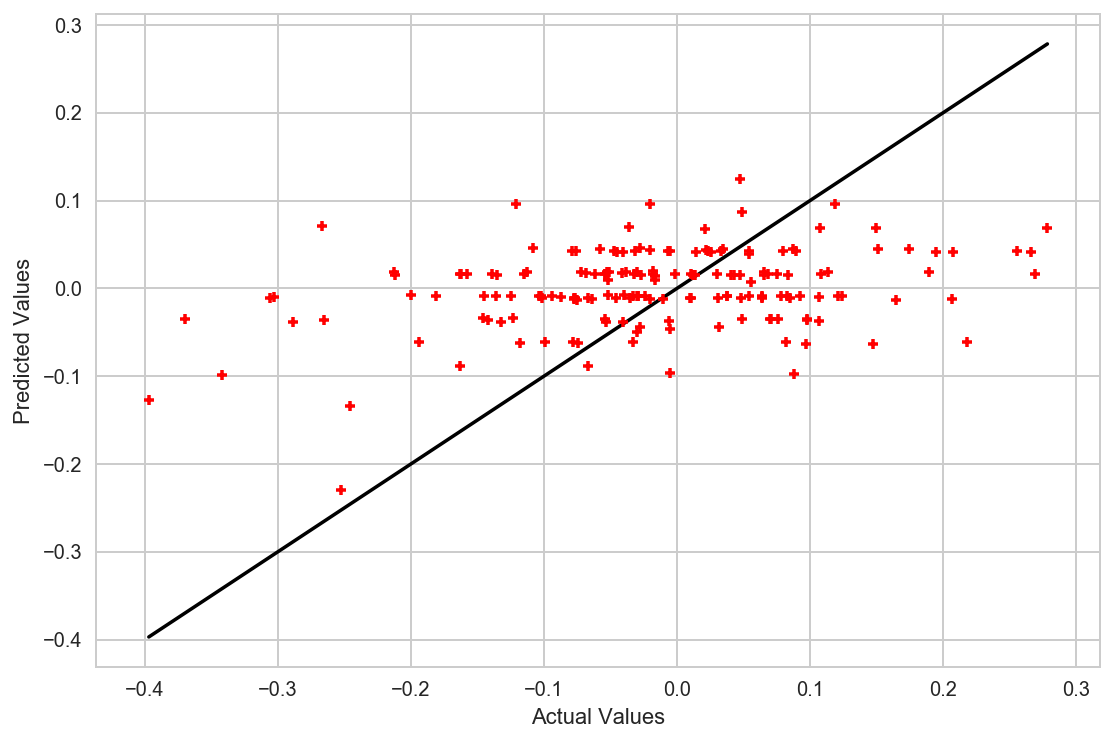

In [689]:
predictions3 = elasticnet_model3.predict(X_test_var_std)
    
print elasticnet_model3.score(X_test_var_std,y_test_var)

plt.figure(figsize=(9,6))
plt.scatter(y_test_var, predictions3, s=30, c='r', marker='+', zorder=10)
plt.plot([min(y_test_var),max(y_test_var)],[min(y_test_var),max(y_test_var)],c='k')
plt.ylabel('Predicted Values')
plt.xlabel('Actual Values')
plt.show()

In [690]:
model_cols3 = []
for i, j in enumerate(elasticnet_model3.coef_):
    if abs(j) > 0:
        model_cols3.append(i)

In [691]:
var_model_columns = [variable_dummy_cols[i] for i in model_cols3]
var_model_coefs = [i for i in elasticnet_model3.coef_ if abs(i) > 0]
feature_df2 = pd.DataFrame({'features': var_model_columns, 'coefs':var_model_coefs})

In [692]:
feature_df2['abs_effect'] = abs(feature_df2.coefs)

The largest factors are in overall quality/condition, which unfortunatly is a little too vague to target in repairs. 

There is very little insight to gain from the second model as far as targets for renovation. However we can add our prediction for the residuals to our fixed model prediction to see the relationship with our actual sales prices. 

In [769]:
sort_feature = feature_df2.sort_values('abs_effect',ascending=False)

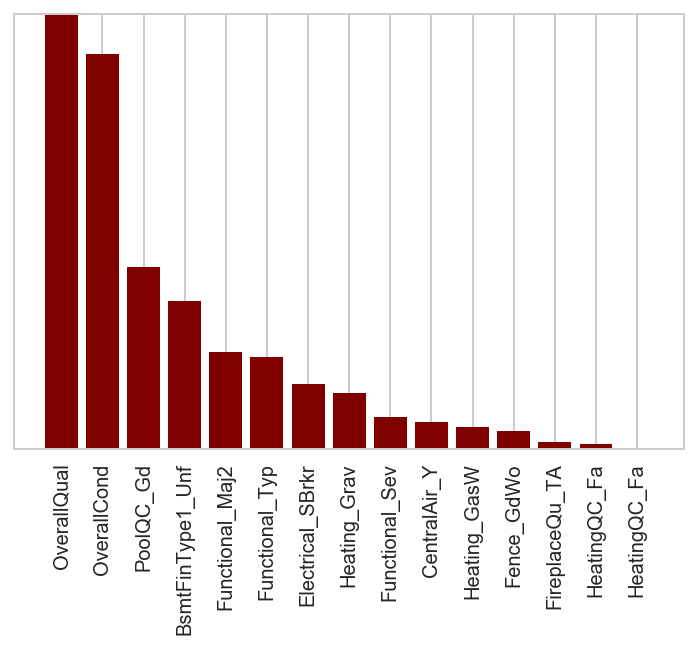

In [772]:
y_pos = np.arange(len(sort_feature['features']))
plt.bar(y_pos,sort_feature['abs_effect'],color=['maroon'])
plt.xticks(y_pos, sort_feature['features'],rotation='vertical')
plt.yticks([])
plt.ylim((0,0.033860))
plt.figure(figsize=(3,100))
plt.show()

Adding our predicted residuals to our predicted prices from the first model should improve the relationship between our prediction and the actual values. It shows below we are able to account for over 95% of the variance between the two models. While the process might not be as explainable, we have traded that for accuracy which will be a strong tool for the future. 

In [698]:
y_predict = np.exp(predictions2)+np.exp(predictions3)

0.955440554433


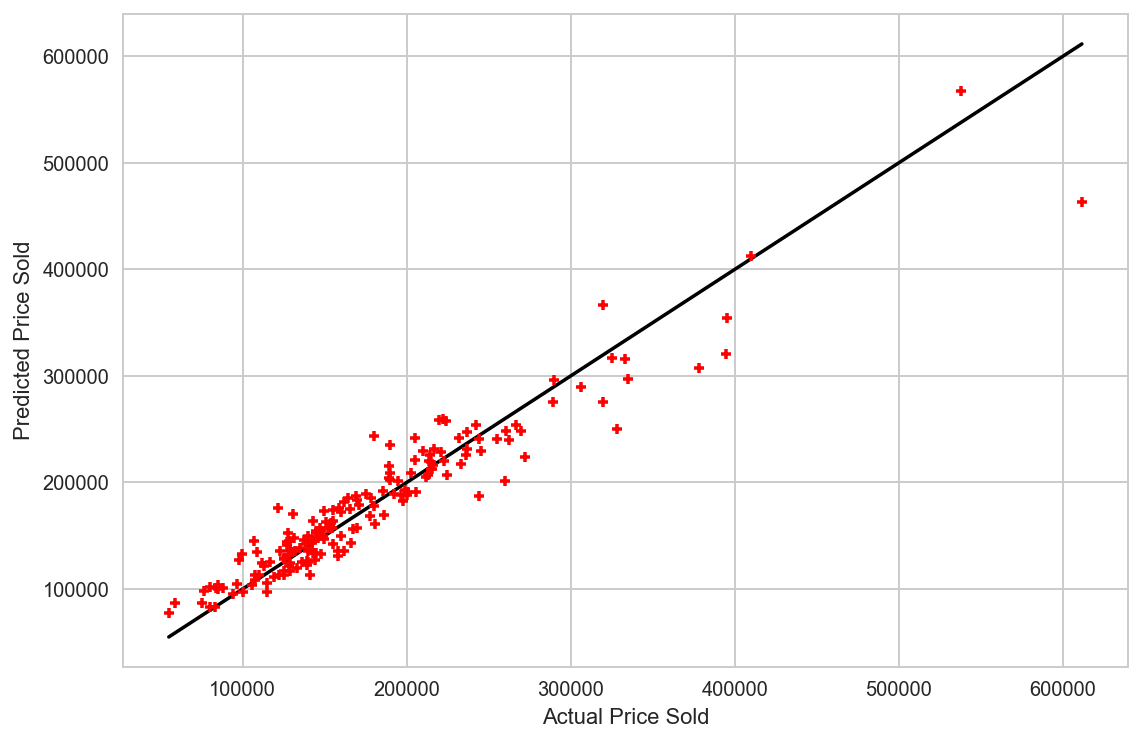

In [757]:
print np.corrcoef(y_test_fixed, y_predict)[0][1]
plt.figure(figsize=(9,6))
plt.scatter(y_test_fixed, y_predict, s=30, c='r', marker='+', zorder=10)
plt.plot([min(y_test_fixed),max(y_test_fixed)],[min(y_test_fixed),max(y_test_fixed)],c='k')
plt.ylabel('Predicted Price Sold')
plt.xlabel('Actual Price Sold')
plt.show()

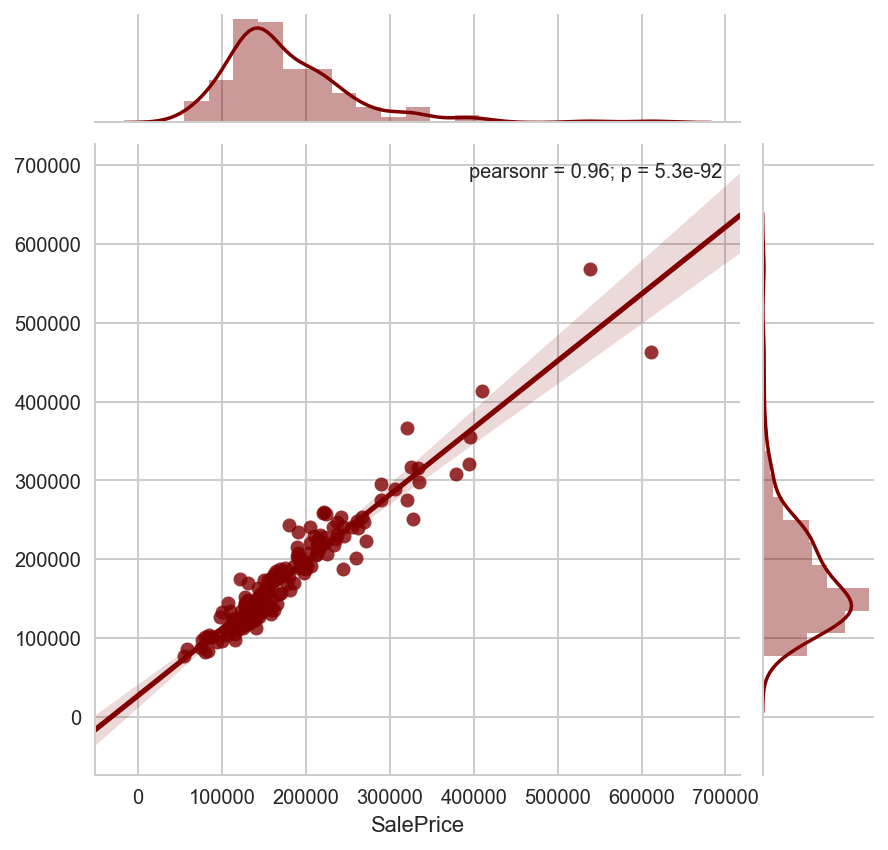

In [778]:
sns.jointplot(y_test_fixed, y_predict,color='maroon',kind='reg',)